In [1]:
# stolen from http://www.chadfulton.com/posts/state_space_mh.html


Bayesian state space estimation in Python via Metropolis-Hastings
This post demonstrates how to use the (http://www.statsmodels.org/) tsa.statespace package along with the PyMC to very simply estimate the parameters of a state space model via the Metropolis-Hastings algorithm (a Bayesian posterior simulation technique).
Although the technique is general to any state space model available in Statsmodels and also to any custom state space model, the provided example is in terms of the local level model and the equivalent ARIMA(0,1,1) model.

In [2]:

%matplotlib inline

import numpy as np
import pandas as pd
import pymc as mc
from scipy import signal
import statsmodels.api as sm
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True, linewidth=120)


Suppose we have a time series $YT≡{yt}Tt=0YT≡{yt}t=0T$ which we model as local level process:
ytμt+1=μt+εt,εt∼N(0,σ2ε)=μt+ηt,ηt∼N(0,σ2η)
yt=μt+εt,εt∼N(0,σε2)μt+1=μt+ηt,ηt∼N(0,ση2)
In this model, there are two unknown parameters, which we will collected in a vector ψψ, so that: ψ=(σ2ε,σ2η)ψ=(σε2,ση2); let's set their true values as follows (denoted with the subscript 0):
ψ0=(σ2ε,0,σ2η,0)=(3,10)
ψ0=(σε,02,ση,02)=(3,10)
Finally, we also must specify the prior μ0∼N(m0,P0)μ0∼N(m0,P0) to initialize the Kalman filter.
Set T=1000T=1000.

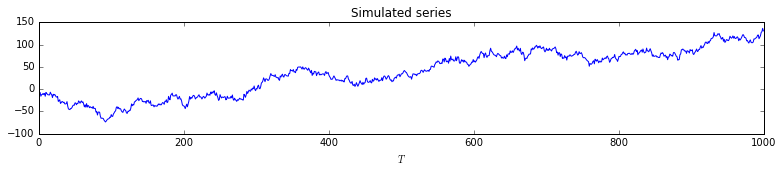

In [3]:

# True values
T = 1000
sigma2_eps0 = 3
sigma2_eta0 = 10

# Simulate data
np.random.seed(1234)
eps = np.random.normal(scale=sigma2_eps0**0.5, size=T)
eta = np.random.normal(scale=sigma2_eta0**0.5, size=T)
mu = np.cumsum(eta)
y = mu + eps

# Plot the time series
fig, ax = plt.subplots(figsize=(13,2))
ax.plot(y);
ax.set(xlabel='$T$', title='Simulated series');


It turns out it will be convenient to write the model in terms of the precision of εε, defined to be h−1≡σ2εh−1≡σε2, and the ratio of the variances: q≡σ2η/σ2εq≡ση2/σε2 so that qh−1=σ2ηqh−1=ση2.
Then our error terms can be written:
εt∼N(0,h−1)ηt∼N(0,qh−1)
εt∼N(0,h−1)ηt∼N(0,qh−1)
And the true values are:
h−10=1/3=0.33h0−1=1/3=0.33
q=10/3=3.33q=10/3=3.33
To take a Bayesian approach to this problem, we assume that ψψ is a random variable, and we want to learn about the values of ψψ based on the data YTYT; in fact we want a density p(ψ|YT)p(ψ|YT). To do this, we use Bayes rule to write:
p(ψ|YT)=p(YT|ψ)p(ψ)p(YT)
p(ψ|YT)=p(YT|ψ)p(ψ)p(YT)
or
p(ψ|YT)⏟posterior∝p(YT|ψ)⏟likelihoodp(ψ)⏟prior
p(ψ|YT)⏟posterior∝p(YT|ψ)⏟likelihoodp(ψ)⏟prior
The object of interest is the posterior; to achieve it we need to specify a prior density for the unknown parameters and the likelihood function of the model.
Prior
We will use the following priors:
Precision
Since the precision must be positive, but has no theoretical upper bound, we use a Gamma prior:
h∼Gamma(αh,βh)
h∼Gamma(αh,βh)
to be specific, the density is written:
p(h)=βαhhΓ(α)hαh−1e−βhh
p(h)=βhαhΓ(α)hαh−1e−βhh
and we set the hyperparameters as αh=2,βh=2αh=2,βh=2. In this case, we have E(h)=αh/βh=1E(h)=αh/βh=1 and also E(h−1)=E(σ2ε)=1E(h−1)=E(σε2)=1.
Ratio of variances
Similarly, the ratio of variances must be positive, but has no theoretical upper bound, so we again use an (independent) Gamma prior:
q∼Gamma(αq,βq)
q∼Gamma(αq,βq)
and we set the same hyperparameters, so αq=2,βq=2αq=2,βq=2. Since E(q)=1E(q)=1, our prior is of equal variances. We then have E(σ2η)=E(qh−1)=E(q)E(h−1)=1E(ση2)=E(qh−1)=E(q)E(h−1)=1.
Initial state prior
As noted above, the Kalman filter must be initialized with μ0∼N(m0,P0)μ0∼N(m0,P0). We will use the following approximately diffuse prior:
μ0∼N(0,106)
μ0∼N(0,106)
Likelihood
For given parameters, likelihood of this model can be calculated via prediction error decomposition using an application of the Kalman filter iterations.
Posterior Simulation: Metropolis-Hastings
One option for describing the posterior is via MCMC posterior simulation methods. The Metropolis-Hastings algorthm is simple and only requires the ability to evaluate the prior densities and the likelihood. The priors have known densities, and the likelihood function can be computed using the state space models from the Statsmodels tsa.statespace package. We will use the PyMC package to streamline specification of priors and sampling in the Metropolis-Hastings case.
The statespace package is meant to make it easy to specify and evaluate state space models. Below, we create a new LocalLevel class. Among other things, it inherits from MLEModel a loglike method which we can use to evaluate the likelihood at various parameters.

In [4]:
# Priors
precision = mc.Gamma('precision', 2, 4)
ratio = mc.Gamma('ratio', 2, 1)

# Likelihood calculated using the state-space model
class LocalLevel(sm.tsa.statespace.MLEModel):
    def __init__(self, endog):
        # Initialize the state space model
        super(LocalLevel, self).__init__(endog, k_states=1,
                                         initialization='approximate_diffuse',
                                         loglikelihood_burn=1)
        
        # Initialize known components of the state space matrices
        self.ssm['design', :] = 1
        self.ssm['transition', :] = 1
        self.ssm['selection', :] = 1
    
    @property
    def start_params(self):
        return [1. / np.var(self.endog), 1.]
    
    @property
    def param_names(self):
        return ['h_inv', 'q']
    
    def update(self, params, transformed=True):
        params = super(LocalLevel, self).update(params, transformed)
        
        h, q = params
        sigma2_eps = 1. / h
        sigma2_eta = q * sigma2_eps
        
        self.ssm['obs_cov', 0, 0] = sigma2_eps
        self.ssm['state_cov', 0, 0] = sigma2_eta

# Instantiate the local level model with our simulated data
ll_mod = LocalLevel(y)

# Create the stochastic (observed) component
@mc.stochastic(dtype=LocalLevel, observed=True)
def local_level(value=ll_mod, h=precision, q=ratio):
    return value.loglike([h, q], transformed=True)

# Create the PyMC model
ll_mc = mc.Model((precision, ratio, local_level))

# Create a PyMC sample
ll_sampler = mc.MCMC(ll_mc)

AttributeError: module 'statsmodels.tsa.api' has no attribute 'statespace'